In [1]:
# Step 1: Install required libraries (Colab usually has these)
!pip install torch torchvision matplotlib --quiet

In [2]:
# Step 2: Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

In [3]:
# Step 3: Data preprocessing
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(224, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

# Level 2: Reload dataset with augmentation

full_train_dataset = datasets.CIFAR10(
    root="./data", train=True,
    download=True, transform=train_transform
)

test_dataset = datasets.CIFAR10(
    root="./data", train=False,
    download=True, transform=test_transform
)

train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_train_dataset, [train_size, val_size]
)

# validation should NOT use augmentation
val_dataset.dataset.transform = test_transform

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("Dataset loaded successfully")

100%|██████████| 170M/170M [00:51<00:00, 3.28MB/s]


Dataset loaded successfully


In [4]:
# Step 4: Load pre-trained ResNet18
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)

# Replace final layer (because CIFAR-10 has 10 classes)
model.fc = nn.Linear(model.fc.in_features, 10)

model = model.to(device)

print("Model loaded on", device)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 137MB/s]


Model loaded on cuda


In [5]:
# Step 5: Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [6]:
# Step 6: Training loop
epochs = 5

train_acc, val_acc = [], []

for epoch in range(epochs):
    model.train()
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    train_acc.append(train_accuracy)

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    val_acc.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_accuracy:.2f}% | Val Acc: {val_accuracy:.2f}%")

Epoch 1/5 | Train Acc: 88.56% | Val Acc: 93.26%
Epoch 2/5 | Train Acc: 96.91% | Val Acc: 93.88%
Epoch 3/5 | Train Acc: 98.80% | Val Acc: 94.57%
Epoch 4/5 | Train Acc: 99.30% | Val Acc: 93.54%
Epoch 5/5 | Train Acc: 98.89% | Val Acc: 93.23%


In [7]:
# Step 7: Test evaluation
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 92.53%


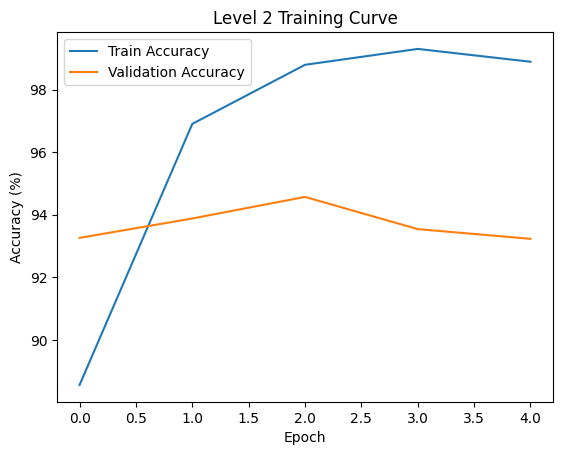

In [8]:
# Step 8: Plot training curve
plt.plot(train_acc, label="Train Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Level 2 Training Curve")
plt.show()

In [9]:
# Level 3: CIFAR-10 class names
classes = (
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
)

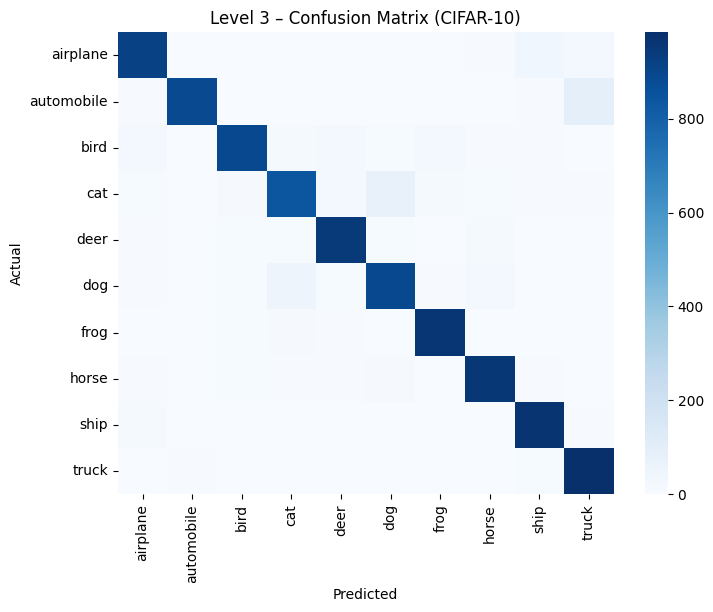

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Collect predictions
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=False, cmap="Blues",
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Level 3 – Confusion Matrix (CIFAR-10)")
plt.show()


In [11]:
# Grad-CAM implementation
from torchvision.models import resnet18

def generate_gradcam(model, image, target_class):
    model.eval()

    gradients = []
    activations = []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    def forward_hook(module, input, output):
        activations.append(output)

    layer = model.layer4[-1]
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)

    output = model(image)
    model.zero_grad()
    output[0, target_class].backward()

    grad = gradients[0]
    act = activations[0]

    weights = torch.mean(grad, dim=(2,3), keepdim=True)
    cam = torch.sum(weights * act, dim=1).squeeze()
    cam = torch.relu(cam)
    cam /= cam.max()

    return cam.cpu().detach().numpy()

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


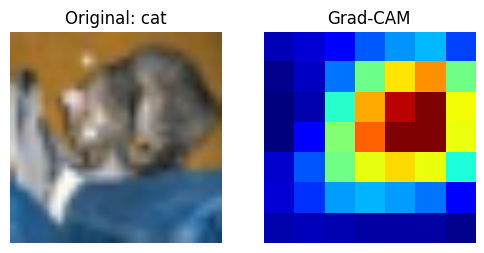

In [12]:
# Pick one test image
image, label = test_dataset[0]
input_image = image.unsqueeze(0).to(device)

# Generate CAM
cam = generate_gradcam(model, input_image, label)

# Plot
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(image.permute(1,2,0)*0.5 + 0.5)
plt.title(f"Original: {classes[label]}")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(cam, cmap="jet")
plt.title("Grad-CAM")
plt.axis("off")

plt.show()

# LEVEL 4 – Ensemble Learning
## Model 2: ResNet-34

In [13]:
# Load ResNet-34
model_resnet34 = models.resnet34(pretrained=True)
model_resnet34.fc = nn.Linear(model_resnet34.fc.in_features, 10)
model_resnet34 = model_resnet34.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet34.parameters(), lr=0.0001)

# Train for fewer epochs (3 is enough)
epochs = 3
for epoch in range(epochs):
    model_resnet34.train()
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_resnet34(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    acc = 100 * correct / total
    print(f"ResNet34 Epoch {epoch+1}/{epochs} - Train Acc: {acc:.2f}%")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 222MB/s]


ResNet34 Epoch 1/3 - Train Acc: 90.22%
ResNet34 Epoch 2/3 - Train Acc: 96.77%
ResNet34 Epoch 3/3 - Train Acc: 98.05%


## Model 3: EfficientNet-B0


In [14]:
# Load EfficientNet-B0
model_eff = models.efficientnet_b0(pretrained=True)
model_eff.classifier[1] = nn.Linear(model_eff.classifier[1].in_features, 10)
model_eff = model_eff.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_eff.parameters(), lr=0.0001)

epochs = 3
for epoch in range(epochs):
    model_eff.train()
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_eff(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    acc = 100 * correct / total
    print(f"EfficientNet Epoch {epoch+1}/{epochs} - Train Acc: {acc:.2f}%")

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 20.5M/20.5M [00:00<00:00, 146MB/s]


EfficientNet Epoch 1/3 - Train Acc: 86.00%
EfficientNet Epoch 2/3 - Train Acc: 95.28%
EfficientNet Epoch 3/3 - Train Acc: 97.23%


In [15]:
# Level 4: Ensemble Voting
import numpy as np

models_list = [model, model_resnet34, model_eff]
for m in models_list:
    m.eval()

y_true = []
y_ensemble = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)

        preds = []
        for m in models_list:
            outputs = m(images)
            preds.append(torch.argmax(outputs, 1).cpu().numpy())

        preds = np.stack(preds)
        ensemble_preds = np.apply_along_axis(
            lambda x: np.bincount(x).argmax(), axis=0, arr=preds
        )

        y_ensemble.extend(ensemble_preds)
        y_true.extend(labels.numpy())

# Ensemble accuracy
ensemble_acc = np.mean(np.array(y_true) == np.array(y_ensemble)) * 100
print(f"Ensemble Test Accuracy: {ensemble_acc:.2f}%")

Ensemble Test Accuracy: 96.09%
